In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

#import plotnine
#from plotnine import *

In [2]:
# 경로 설정
data_path = '/Data2/hm22/New/data'
saved_path = '/Data2/hm22/New/code/saved'
output_path = '/Data2/hm22/New/code/submission'

In [3]:
# 데이터 불러오기 
history = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
watch = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
# buy = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')  # 사용 X
search = pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
profile = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')

In [4]:
hd = history.copy()
wd = watch.copy()
#bd = buy.copy()
sd = search.copy()
prd = profile.copy()

In [5]:
print('hd 데이터(중복 제거 전) : ', hd.shape)
print('wd 데이터(중복 제거 전) : ', wd.shape)
print('sd 데이터(중복 제거 전) : ', sd.shape)
print('prd 데이터(중복 제거 전) : ', prd.shape)

hd 데이터(중복 제거 전) :  (1005651, 8)
wd 데이터(중복 제거 전) :  (892794, 8)
sd 데이터(중복 제거 전) :  (6474, 5)
prd 데이터(중복 제거 전) :  (8311, 9)


### 1. 중복 데이터 제거

In [6]:
# 중복행 확인
hd[hd.duplicated()] # 시청시작 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
517,5,20220421082427,20220421082957,MKID003,92,NaN,N,N
519,5,20220421082427,20220421085009,MKID003,174,NaN,N,N
521,5,20220421082427,20220421090237,MKID003,201,NaN,N,N
523,5,20220421082427,20220421090332,MKID003,187,NaN,N,N
525,5,20220421082427,20220421090449,MKID003,305,NaN,N,N
...,...,...,...,...,...,...,...,...
1004498,32908,20220420203843,20220420204139,MKID003,6458,NaN,N,N
1005467,33015,20220424194027,20220424194036,MKID003,416,NaN,Y,N
1005469,33015,20220424194027,20220424194091,MKID003,175,NaN,N,Y
1005471,33015,20220424195608,20220424195612,MKID003,57,NaN,N,N


In [7]:
wd[wd.duplicated()] # 시청종료 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
507,5,20220421082427,20220421082953,MKID049,298,307,309,1
509,5,20220421082427,20220421085005,MKID049,92,1207,1207,1
511,5,20220421082427,20220421090233,MKID049,174,744,745,1
513,5,20220421082427,20220421090327,MKID049,201,50,50,1
515,5,20220421082427,20220421090443,MKID049,187,70,70,1
...,...,...,...,...,...,...,...,...
892571,33016,20220424194881,20220424195327,MKID049,5873,94,94,1
892573,33016,20220424194881,20220424195543,MKID049,5874,94,94,1
892575,33016,20220424194881,20220424195570,MKID049,5874,50,94,0
892577,33016,20220424194881,20220424195683,MKID049,4598,34,95,0


In [8]:
sd[sd.duplicated()] # 검색 데이터

,profile_id,ss_id,log_time,act_target_dtl,album_id
1,59,20220303183951,20220303183914,MKID017,2141
2,59,20220303183951,20220303183914,MKID017,2141
11,59,20220401092854,20220401092812,MKID017,2157
13,59,20220401092762,20220401092842,MKID017,2158
67,572,20220306172399,20220306172797,MKID017,2867
...,...,...,...,...,...
6366,32000,20220404195999,20220404195946,MKID017,2009
6367,32000,20220404195999,20220404195946,MKID017,2009
6387,32193,20220413135709,20220413135982,MKID017,26071
6402,32322,20220328175541,20220328180237,MKID017,10006


In [9]:
prd[prd.duplicated()] # 프로필 데이터

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3


In [10]:
# 중복행 제거
hd = hd[~hd.duplicated()]
print('hd 데이터(중복 제거 후) : ', hd.shape) # 약 10% 감소

wd = wd[~wd.duplicated()]
print('wd 데이터(중복 제거 후) : ', wd.shape) # 약 10% 감소

sd = sd[~sd.duplicated()]
print('sd 데이터(중복 제거 후) : ', sd.shape)

hd 데이터(중복 제거 후) :  (899273, 8)
wd 데이터(중복 제거 후) :  (800740, 8)
sd 데이터(중복 제거 후) :  (5825, 5)


### 2. 결측치 제거

#### 2-1. History data 내 payment

In [12]:
hd.isnull().sum(), wd.isnull().sum(), sd.isnull().sum(), prd.isnull().sum()

(profile_id              0
 ss_id                   0
 log_time                0
 act_target_dtl          0
 album_id                0
 payment            840080
 continuous_play         0
 short_trailer           0
 dtype: int64,
 profile_id         0
 ss_id              0
 log_time           0
 act_target_dtl     0
 album_id           0
 watch_time         0
 total_time         0
 continuous_play    0
 dtype: int64,
 profile_id        0
 ss_id             0
 log_time          0
 act_target_dtl    0
 album_id          0
 dtype: int64,
 profile_id                     0
 sex                            0
 age                            0
 pr_interest_keyword_cd_1       0
 pr_interest_keyword_cd_2    1533
 pr_interest_keyword_cd_3    2080
 ch_interest_keyword_cd_1       0
 ch_interest_keyword_cd_2    1693
 ch_interest_keyword_cd_3    2282
 dtype: int64)

In [13]:
def nonull(df) :
    
    print("null 값 대체 전 결측치 개수 : ", df['payment'].isnull().sum()) #null 값 대체 전 결측치 개수
    
    # ID 별 payment의 합을 구하기
    ddff = df.groupby('profile_id').sum()
    
    print("payment의 합 == 0인 ID 개수 : ", len(ddff[ddff['payment'] == 0.0].index)) #payment의 합 == 0인 ID 개수
    
    """
    아래 코드 잘못됨
    for i in ddff[ddff['payment'] == 0.0].index : 
        if all(dfcp['profile_id'] == i) :
            dfcp['payment_nonan'] = dfcp['payment'].fillna(0) #payment 정보가 누락된 ID가 누구인지 추출한 후, 해당 ID의 payment 결측값을 0으로 대체
    """ 
    
    for i in ddff[ddff['payment'] == 0.0].index: 
        df[df['profile_id'] == i]
        df['payment_nonan'] = df['payment'].fillna(0) #payment 정보가 누락된 ID가 누구인지 추출한 후, 해당 ID의 payment 결측값을 0으로 대체
    
    
    a = df[df['payment_nonan'] != 0.0]['payment']
    b = df[df['payment'].notnull()]['payment']
    
    print(a.equals(b))
    
    df.drop(labels='payment',axis=1, inplace = True)
    df.rename(columns={'payment_nonan':'payment'}, inplace = True)
    
    print("null 값 대체 후 결측치 개수 : ", df['payment'].isnull().sum()) #null 값 대체 후 결측치 개수
    
    return df

In [14]:
hd = nonull(hd)

null 값 대체 전 결측치 개수 :  840080
payment의 합 == 0인 ID 개수 :  6619
True
null 값 대체 후 결측치 개수 :  0


#### 2-2. Profile data 내 결측치 처리

In [15]:
prd.isnull().sum().to_frame()

,0
profile_id,0
sex,0
age,0
pr_interest_keyword_cd_1,0
pr_interest_keyword_cd_2,1533
pr_interest_keyword_cd_3,2080
ch_interest_keyword_cd_1,0
ch_interest_keyword_cd_2,1693
ch_interest_keyword_cd_3,2282


In [16]:
prd[prd['pr_interest_keyword_cd_2'].isnull()]

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
7,22,F,4,P06,NaN,NaN,K01,NaN,NaN
22,74,M,2,P02,NaN,NaN,K03,NaN,NaN
33,115,M,4,P06,NaN,NaN,K01,NaN,NaN
37,122,M,3,P05,NaN,NaN,K08,NaN,NaN
41,130,F,10,P07,NaN,NaN,K06,NaN,NaN
...,...,...,...,...,...,...,...,...,...
8290,32965,M,1,P01,NaN,NaN,K01,K08,NaN
8294,32978,F,4,P06,NaN,NaN,K06,K01,K03
8297,32984,F,4,P06,NaN,NaN,K01,K02,K04
8301,33000,M,3,P07,NaN,NaN,K01,NaN,NaN


In [17]:
prd['pr_interest_keyword_cd_2'] = prd['pr_interest_keyword_cd_2'].fillna(prd['pr_interest_keyword_cd_1'])
prd['pr_interest_keyword_cd_3'] = prd['pr_interest_keyword_cd_3'].fillna(prd['pr_interest_keyword_cd_1'])
prd['ch_interest_keyword_cd_2'] = prd['ch_interest_keyword_cd_2'].fillna(prd['ch_interest_keyword_cd_1'])
prd['ch_interest_keyword_cd_3'] = prd['ch_interest_keyword_cd_3'].fillna(prd['ch_interest_keyword_cd_1'])

In [18]:
prd.isnull().sum().to_frame()

,0
profile_id,0
sex,0
age,0
pr_interest_keyword_cd_1,0
pr_interest_keyword_cd_2,0
pr_interest_keyword_cd_3,0
ch_interest_keyword_cd_1,0
ch_interest_keyword_cd_2,0
ch_interest_keyword_cd_3,0


### 3. 이상치 제거

#### 3-1. History_data 내 log_time 이상치 제거

In [19]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0


In [20]:
# log_time 날짜/시간 분리
hd["log_time"] = hd["log_time"].astype(str)
hd["date"] = hd["log_time"].str.slice(0, 8)
hd["time"] = hd["log_time"].str.slice(8, 14)

In [21]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,date,time
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0,20220301,115719
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0,20220301,115809
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0,20220301,115958
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0,20220301,120118
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0,20220301,120229


In [22]:
# 월 조건 (3 ~ 7월 제외한 월이 있는지)
con1 = (hd['date'].str[4:6] != '03')
con2 = (hd['date'].str[4:6] != '04')
con3 = (hd['date'].str[4:6] != '05')
con4 = (hd['date'].str[4:6] != '06')
con5 = (hd['date'].str[4:6] != '07')

# 일 조건 (0일 / 00일 / 32일 이상 있는지)
con8 = (hd['date'].str[6:8] == '0')
con9 = (hd['date'].str[6:8] == '00')
con10 = (hd['date'].str[6:8].astype(int) >= 32)

In [23]:
print('조건에 맞지 않는 연도 수:', len(hd.loc[hd['date'].str[:4] != '2022']))
print('조건에 맞지 않는 월 수:', len(hd.loc[con1 & con2 & con3 & con4 & con5]))
print('조건에 맞지 않는 일 수:', len(hd.loc[con8 | con9 | con10]))
print('조건에 맞지 않는 시 수:', len(hd.loc[hd['time'].str[:2] >= '24']))
print('조건에 맞지 않는 분 수:', len(hd.loc[hd['time'].str[2:4] >= '60']))
print('조건에 맞지 않는 초 수:', len(hd.loc[hd['time'].str[4:6] >= '60']))

조건에 맞지 않는 연도 수: 0
조건에 맞지 않는 월 수: 0
조건에 맞지 않는 일 수: 0
조건에 맞지 않는 시 수: 0
조건에 맞지 않는 분 수: 0
조건에 맞지 않는 초 수: 73581


In [24]:
# 초에만 이상 있음
# 이상 있는 데이터 73,581개
hd.loc[hd['time'].str[4:6] >= '60']

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,date,time
2975,30,20220305130048,20220305131273,MKID003,1901,Y,N,0.0,20220305,131273
2976,30,20220305130048,20220305132966,MKID003,1902,Y,N,0.0,20220305,132966
2978,30,20220305130048,20220305134092,MKID003,1903,Y,N,0.0,20220305,134092
2983,30,20220320140092,20220320140174,MKID003,446,N,N,500.0,20220320,140174
2988,30,20220320140092,20220320144788,MKID003,1908,Y,N,500.0,20220320,144788
...,...,...,...,...,...,...,...,...,...,...
1005638,33032,20220427151499,20220427154870,MKID003,7105,N,N,0.0,20220427,154870
1005639,33032,20220427151499,20220427155075,MKID003,1725,Y,N,0.0,20220427,155075
1005646,33032,20220427155091,20220427155668,MKID003,381,Y,N,0.0,20220427,155668
1005647,33032,20220427155091,20220427155680,MKID003,381,Y,N,0.0,20220427,155680


In [25]:
# 이상 데이터 제거
hd = hd.drop(hd.loc[hd['time'].str[4:6] >= '60'].index)
print('이상 데이터 제거 후:', len(hd))

이상 데이터 제거 후: 825692


In [27]:
print('조건에 맞지 않는 초 수:', len(hd.loc[hd['time'].str[4:6] >= '60']))

조건에 맞지 않는 초 수: 0


In [28]:
hd.drop(labels=['date', 'time'],axis=1, inplace = True)

In [29]:
# log_time type 다시 int형으로 변경
hd["log_time"] = hd["log_time"].astype(int)

#### 3-2. Watch_data 내 시청시간, 콘텐츠 길이 이상치 제거

In [30]:
# LocalOutlierFactor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

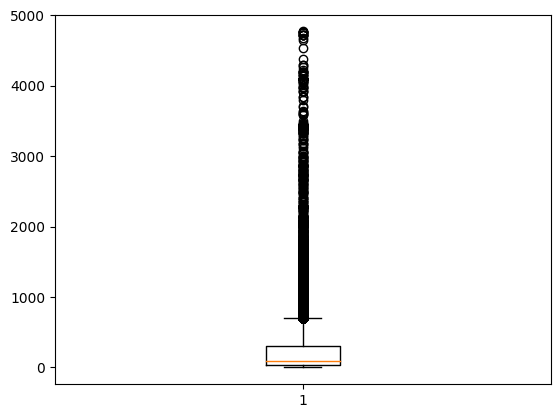

In [31]:
fig, ax = plt.subplots()
ax.boxplot(wd['watch_time'])
plt.show()

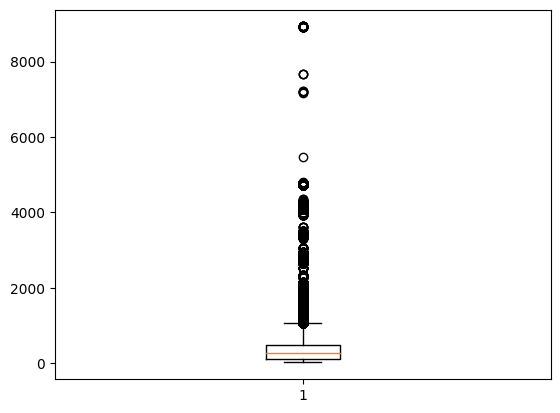

In [32]:
fig, ax = plt.subplots()
ax.boxplot(wd['total_time'])
plt.show()

In [33]:
wd02 = wd.copy()
wd02 = wd02[['watch_time', 'total_time']]

In [34]:
outlier = LocalOutlierFactor()
wd02["outlier"] = outlier.fit_predict(wd02)

In [35]:
# 이상치 탐지 (이상치 있는 행 찾기)
wd02[wd02["outlier"] == -1]

,watch_time,total_time,outlier
22,18,93,-1
96,22,122,-1
152,18,324,-1
209,23,116,-1
225,13,115,-1
...,...,...,...
892705,24,661,-1
892711,45,661,-1
892722,15,703,-1
892728,0,157,-1


In [36]:
wd = wd.drop(wd02[wd02["outlier"] == -1].index, axis = 0)

In [37]:
print('wd 데이터(이상치 제거 후) : ', wd.shape) # wd 데이터(이상치 제거 전) :  (800740, 8)

wd 데이터(이상치 제거 후) :  (762755, 8)


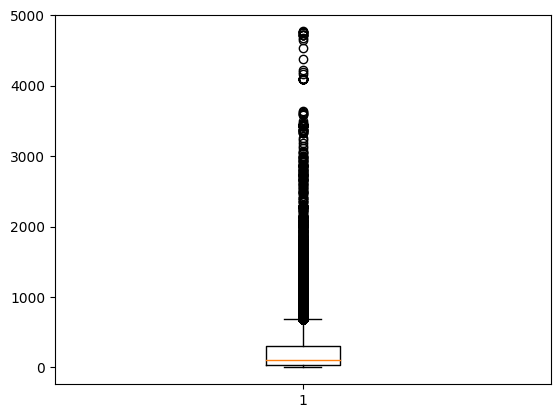

In [38]:
fig, ax = plt.subplots()
ax.boxplot(wd['watch_time'])
plt.show()

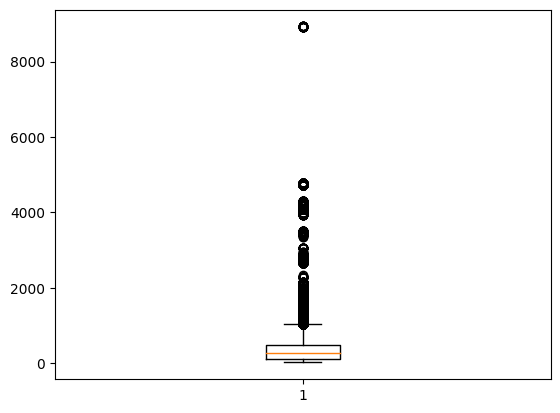

In [39]:
fig, ax = plt.subplots()
ax.boxplot(wd['total_time'])
plt.show()

#### 3-3. History_data 내 payment 이상치 제거

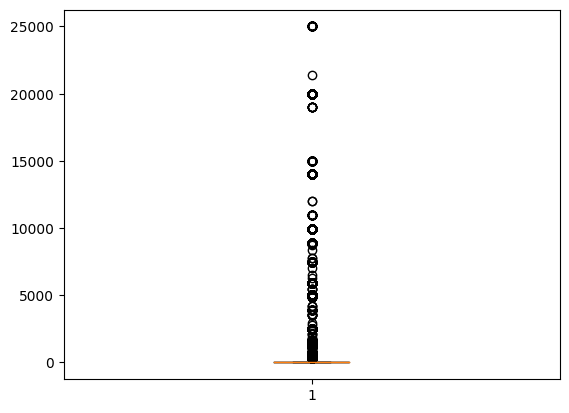

In [40]:
fig, ax = plt.subplots()
ax.boxplot(hd['payment'])
plt.show()

### 4. 파생변수

#### 4-1. 선호도('prefer') 변수

In [41]:
wd.tail()

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play
892789,33032,20220427155091,20220427155653,MKID049,381,463,464,1
892790,33032,20220427155091,20220427155694,MKID049,381,462,463,1
892791,33032,20220427155839,20220427155826,MKID049,125,10,520,0
892792,33032,20220427155706,20220427155836,MKID049,125,6,521,0
892793,33032,20220427155839,20220427155897,MKID049,381,462,464,1


In [42]:
#컬럼추가
wd_prefer = wd.copy()
wd_prefer['prefer'] = np.nan
wd_prefer.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,prefer
0,3,20220301115653,20220301115805,MKID049,15,46,46,1,NaN
1,3,20220301115653,20220301115954,MKID049,16,104,105,1,NaN
2,3,20220301115653,20220301120114,MKID049,17,76,76,1,NaN
3,3,20220301115653,20220301120226,MKID049,18,67,68,1,NaN
4,3,20220301115653,20220301120400,MKID049,19,90,90,0,NaN


In [43]:
#조건걸어서
#새컬럼에 값추가 1 ~ 4

for i in wd_prefer.index : 
    
    try : 
        #wd_prefer_check = wd_prefer.iloc[i]
        if wd_prefer.loc[i].watch_time < wd_prefer.loc[i].total_time * 0.25 :
            wd_prefer.loc[i,'prefer'] = 1
        elif wd_prefer.loc[i].watch_time < wd_prefer.loc[i].total_time * 0.5 :
            wd_prefer.loc[i,'prefer'] = 2
        elif wd_prefer.loc[i].watch_time < wd_prefer.loc[i].total_time * 0.75 :
            wd_prefer.loc[i,'prefer'] = 3
        else : 
            wd_prefer.loc[i,'prefer'] = 4
        
    except : 
        pass

In [44]:
wd = wd_prefer
wd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,prefer
0,3,20220301115653,20220301115805,MKID049,15,46,46,1,4.0
1,3,20220301115653,20220301115954,MKID049,16,104,105,1,4.0
2,3,20220301115653,20220301120114,MKID049,17,76,76,1,4.0
3,3,20220301115653,20220301120226,MKID049,18,67,68,1,4.0
4,3,20220301115653,20220301120400,MKID049,19,90,90,0,4.0


#### 4-2. log_time 시간대 파생변수 생성

In [45]:
# log_time에서 시간만 분리
hd["log_time"] = hd["log_time"].astype(str)
hd["time"] = hd["log_time"].str[8:10].astype(int)

In [46]:
conditionlist = [
    (hd['time'] < 6) ,
    (hd['time'] >= 6) & (hd['time'] < 12),
    (hd['time'] >= 12) & (hd['time'] < 18),
    (hd['time'] >= 18) & (hd['time'] < 24)]
choicelist = [1, 2, 3, 4]
hd['time_slot'] = np.select(conditionlist, choicelist)

In [47]:
hd = hd.drop(['time'], axis = 1) # time열 drop
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,time_slot
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0,2
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0,2
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0,2
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0,3
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0,3


In [48]:
hd["log_time"] = hd["log_time"].astype(int)

In [49]:
##### 중간 저장

# 각 데이터셋 저장
hd.to_csv('hd_v2_lof.csv')
wd.to_csv('wd_v2_lof.csv')
sd.to_csv('sd_v2_lof.csv')
prd.to_csv('prd_v2_lof.csv')

In [105]:
# 데이터 불러오기 
hd = pd.read_csv('/Data2/hm22/New/hd_v2_lof.csv', encoding='utf-8')
wd = pd.read_csv('/Data2/hm22/New/wd_v2_lof.csv', encoding='utf-8')
sd = pd.read_csv('/Data2/hm22/New/sd_v2_lof.csv', encoding='utf-8')
prd = pd.read_csv('/Data2/hm22/New/prd_v2_lof.csv', encoding='utf-8')

hd = hd.drop(['Unnamed: 0'], axis = 1)
wd = wd.drop(['Unnamed: 0'], axis = 1)
sd = sd.drop(['Unnamed: 0'], axis = 1)
prd = prd.drop(['Unnamed: 0'], axis = 1)

### 5. 데이터 병합

#### 5-1. HD(시청 시작) + SD(검색 후 시청 시작)

In [106]:
hd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,continuous_play,short_trailer,payment,time_slot
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0,2
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0,2
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0,2
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0,3
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0,3


In [107]:
sd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id
0,59,20220303183951,20220303183914,MKID017,2141
1,59,20220304181433,20220304181525,MKID017,512
2,59,20220304181433,20220304182447,MKID017,2141
3,59,20220312071555,20220312071637,MKID017,2142
4,59,20220312071555,20220312081857,MKID017,2142


In [108]:
df01 = pd.merge(hd, sd, on = ['profile_id', 'ss_id', 'album_id', 'log_time'], how = 'left')
df01

,profile_id,ss_id,log_time,act_target_dtl_x,album_id,continuous_play,short_trailer,payment,time_slot,act_target_dtl_y
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0,2,NaN
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0,2,NaN
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0,2,NaN
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0,3,NaN
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0,3,NaN
...,...,...,...,...,...,...,...,...,...,...
825687,33032,20220427155091,20220427155601,MKID003,381,Y,N,0.0,3,NaN
825688,33032,20220427155091,20220427155611,MKID003,381,Y,N,0.0,3,NaN
825689,33032,20220427155091,20220427155642,MKID003,381,N,N,0.0,3,NaN
825690,33032,20220427155839,20220427155810,MKID003,125,Y,N,0.0,3,NaN


In [109]:
print('hd 데이터 : ', hd.shape)
print('hd 데이터(검색 데이터 합) : ', df01.shape)

hd 데이터 :  (825692, 9)
hd 데이터(검색 데이터 합) :  (825692, 10)


In [110]:
hd.columns, df01.columns

(Index(['profile_id', 'ss_id', 'log_time', 'act_target_dtl', 'album_id',
        'continuous_play', 'short_trailer', 'payment', 'time_slot'],
       dtype='object'),
 Index(['profile_id', 'ss_id', 'log_time', 'act_target_dtl_x', 'album_id',
        'continuous_play', 'short_trailer', 'payment', 'time_slot',
        'act_target_dtl_y'],
       dtype='object'))

#### 5-2. HD(시청 시작) + SD(검색 후 시청 시작) + WD(시청 종료)

In [111]:
df01.head()

,profile_id,ss_id,log_time,act_target_dtl_x,album_id,continuous_play,short_trailer,payment,time_slot,act_target_dtl_y
0,3,20220301115653,20220301115719,MKID003,15,Y,N,0.0,2,NaN
1,3,20220301115653,20220301115809,MKID003,16,Y,N,0.0,2,NaN
2,3,20220301115653,20220301115958,MKID003,17,Y,N,0.0,2,NaN
3,3,20220301115653,20220301120118,MKID003,18,Y,N,0.0,3,NaN
4,3,20220301115653,20220301120229,MKID003,19,Y,N,0.0,3,NaN


In [112]:
wd.head()

,profile_id,ss_id,log_time,act_target_dtl,album_id,watch_time,total_time,continuous_play,prefer
0,3,20220301115653,20220301115805,MKID049,15,46,46,1,4.0
1,3,20220301115653,20220301115954,MKID049,16,104,105,1,4.0
2,3,20220301115653,20220301120114,MKID049,17,76,76,1,4.0
3,3,20220301115653,20220301120226,MKID049,18,67,68,1,4.0
4,3,20220301115653,20220301120400,MKID049,19,90,90,0,4.0


In [113]:
%%time
df02 = pd.merge(df01, wd, on = ['profile_id', 'ss_id', 'album_id'], how = 'outer')
df02

CPU times: user 783 ms, sys: 568 ms, total: 1.35 s
Wall time: 1.35 s


,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id,continuous_play_x,short_trailer,payment,time_slot,act_target_dtl_y,log_time_y,act_target_dtl,watch_time,total_time,continuous_play_y,prefer
0,3,20220301115653,2.022030e+13,MKID003,15,Y,N,0.0,2.0,NaN,2.022030e+13,MKID049,46.0,46.0,1.0,4.0
1,3,20220301115653,2.022030e+13,MKID003,16,Y,N,0.0,2.0,NaN,2.022030e+13,MKID049,104.0,105.0,1.0,4.0
2,3,20220301115653,2.022030e+13,MKID003,17,Y,N,0.0,2.0,NaN,2.022030e+13,MKID049,76.0,76.0,1.0,4.0
3,3,20220301115653,2.022030e+13,MKID003,18,Y,N,0.0,3.0,NaN,2.022030e+13,MKID049,67.0,68.0,1.0,4.0
4,3,20220301115653,2.022030e+13,MKID003,19,Y,N,0.0,3.0,NaN,2.022030e+13,MKID049,90.0,90.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056807,33032,20220427155091,NaN,NaN,373,NaN,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,7.0,48.0,0.0,1.0
2056808,33032,20220427155091,NaN,NaN,3128,NaN,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,2.0,67.0,0.0,1.0
2056809,33032,20220427155091,NaN,NaN,393,NaN,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,81.0,1036.0,0.0,1.0
2056810,33032,20220427155091,NaN,NaN,3625,NaN,NaN,NaN,NaN,NaN,2.022043e+13,MKID049,9.0,66.0,0.0,1.0


In [114]:
# act_target_dtl_y -> search (검색 여부) 로 변경
df02[df02['act_target_dtl_y']  == 'MKID017'].index

Int64Index([ 455671,  470784,  870929,  870930,  870931,  870932,  870933,
             871989,  871990,  871991,  871992,  871993,  871994,  871995,
             871996,  872002,  872003,  872004,  872075, 1064581, 1064582,
            1105708, 1105709, 1105710, 1199568, 1199960, 1345828],
           dtype='int64')

In [115]:
df02.loc[(df02['act_target_dtl_y']  == 'MKID017'), 'act_target_dtl_y']  = 1
df02['act_target_dtl_y'] = df02['act_target_dtl_y'].fillna(0)

In [116]:
df02.act_target_dtl_y.unique()

array([0, 1])

In [117]:
df02[df02['act_target_dtl_y']  == 1].index

Int64Index([ 455671,  470784,  870929,  870930,  870931,  870932,  870933,
             871989,  871990,  871991,  871992,  871993,  871994,  871995,
             871996,  872002,  872003,  872004,  872075, 1064581, 1064582,
            1105708, 1105709, 1105710, 1199568, 1199960, 1345828],
           dtype='int64')

In [118]:
df02.rename(columns={'act_target_dtl_y':'search_ox'}, inplace = True)

In [119]:
df02

,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id,continuous_play_x,short_trailer,payment,time_slot,search_ox,log_time_y,act_target_dtl,watch_time,total_time,continuous_play_y,prefer
0,3,20220301115653,2.022030e+13,MKID003,15,Y,N,0.0,2.0,0,2.022030e+13,MKID049,46.0,46.0,1.0,4.0
1,3,20220301115653,2.022030e+13,MKID003,16,Y,N,0.0,2.0,0,2.022030e+13,MKID049,104.0,105.0,1.0,4.0
2,3,20220301115653,2.022030e+13,MKID003,17,Y,N,0.0,2.0,0,2.022030e+13,MKID049,76.0,76.0,1.0,4.0
3,3,20220301115653,2.022030e+13,MKID003,18,Y,N,0.0,3.0,0,2.022030e+13,MKID049,67.0,68.0,1.0,4.0
4,3,20220301115653,2.022030e+13,MKID003,19,Y,N,0.0,3.0,0,2.022030e+13,MKID049,90.0,90.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056807,33032,20220427155091,NaN,NaN,373,NaN,NaN,NaN,NaN,0,2.022043e+13,MKID049,7.0,48.0,0.0,1.0
2056808,33032,20220427155091,NaN,NaN,3128,NaN,NaN,NaN,NaN,0,2.022043e+13,MKID049,2.0,67.0,0.0,1.0
2056809,33032,20220427155091,NaN,NaN,393,NaN,NaN,NaN,NaN,0,2.022043e+13,MKID049,81.0,1036.0,0.0,1.0
2056810,33032,20220427155091,NaN,NaN,3625,NaN,NaN,NaN,NaN,0,2.022043e+13,MKID049,9.0,66.0,0.0,1.0


In [120]:
# 중간 저장
df02.to_csv('dfv1.csv')

#### 5-3. HD(시청 시작) + SD(검색 후 시청 시작) + WD(시청 종료) + PRD(프로필 정보)

In [121]:
df02.columns, prd.columns

(Index(['profile_id', 'ss_id', 'log_time_x', 'act_target_dtl_x', 'album_id',
        'continuous_play_x', 'short_trailer', 'payment', 'time_slot',
        'search_ox', 'log_time_y', 'act_target_dtl', 'watch_time', 'total_time',
        'continuous_play_y', 'prefer'],
       dtype='object'),
 Index(['profile_id', 'sex', 'age', 'pr_interest_keyword_cd_1',
        'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
        'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2',
        'ch_interest_keyword_cd_3'],
       dtype='object'))

In [122]:
%%time
all_df = pd.merge(df02, prd, on = ['profile_id'], how = 'right')
all_df

CPU times: user 924 ms, sys: 2.47 s, total: 3.4 s
Wall time: 3.4 s


,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id,continuous_play_x,short_trailer,payment,time_slot,search_ox,...,continuous_play_y,prefer,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,2.022030e+13,2.022030e+13,MKID003,15.0,Y,N,0.0,2.0,0.0,...,1.0,4.0,F,5,P02,P04,P07,K01,K03,K04
1,3,2.022030e+13,2.022030e+13,MKID003,16.0,Y,N,0.0,2.0,0.0,...,1.0,4.0,F,5,P02,P04,P07,K01,K03,K04
2,3,2.022030e+13,2.022030e+13,MKID003,17.0,Y,N,0.0,2.0,0.0,...,1.0,4.0,F,5,P02,P04,P07,K01,K03,K04
3,3,2.022030e+13,2.022030e+13,MKID003,18.0,Y,N,0.0,3.0,0.0,...,1.0,4.0,F,5,P02,P04,P07,K01,K03,K04
4,3,2.022030e+13,2.022030e+13,MKID003,19.0,Y,N,0.0,3.0,0.0,...,0.0,4.0,F,5,P02,P04,P07,K01,K03,K04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056833,33032,2.022043e+13,NaN,NaN,373.0,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09
2056834,33032,2.022043e+13,NaN,NaN,3128.0,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09
2056835,33032,2.022043e+13,NaN,NaN,393.0,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09
2056836,33032,2.022043e+13,NaN,NaN,3625.0,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09


In [123]:
# 저장
all_df.to_csv('all_df_v1.csv')

In [124]:
all_df

,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id,continuous_play_x,short_trailer,payment,time_slot,search_ox,...,continuous_play_y,prefer,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,2.022030e+13,2.022030e+13,MKID003,15.0,Y,N,0.0,2.0,0.0,...,1.0,4.0,F,5,P02,P04,P07,K01,K03,K04
1,3,2.022030e+13,2.022030e+13,MKID003,16.0,Y,N,0.0,2.0,0.0,...,1.0,4.0,F,5,P02,P04,P07,K01,K03,K04
2,3,2.022030e+13,2.022030e+13,MKID003,17.0,Y,N,0.0,2.0,0.0,...,1.0,4.0,F,5,P02,P04,P07,K01,K03,K04
3,3,2.022030e+13,2.022030e+13,MKID003,18.0,Y,N,0.0,3.0,0.0,...,1.0,4.0,F,5,P02,P04,P07,K01,K03,K04
4,3,2.022030e+13,2.022030e+13,MKID003,19.0,Y,N,0.0,3.0,0.0,...,0.0,4.0,F,5,P02,P04,P07,K01,K03,K04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056833,33032,2.022043e+13,NaN,NaN,373.0,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09
2056834,33032,2.022043e+13,NaN,NaN,3128.0,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09
2056835,33032,2.022043e+13,NaN,NaN,393.0,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09
2056836,33032,2.022043e+13,NaN,NaN,3625.0,NaN,NaN,NaN,NaN,0.0,...,0.0,1.0,F,5,P03,P05,P07,K01,K05,K09


In [125]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056838 entries, 0 to 2056837
Data columns (total 24 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   profile_id                int64  
 1   ss_id                     float64
 2   log_time_x                float64
 3   act_target_dtl_x          object 
 4   album_id                  float64
 5   continuous_play_x         object 
 6   short_trailer             object 
 7   payment                   float64
 8   time_slot                 float64
 9   search_ox                 float64
 10  log_time_y                float64
 11  act_target_dtl            object 
 12  watch_time                float64
 13  total_time                float64
 14  continuous_play_y         float64
 15  prefer                    float64
 16  sex                       object 
 17  age                       int64  
 18  pr_interest_keyword_cd_1  object 
 19  pr_interest_keyword_cd_2  object 
 20  pr_interest_keyword_cd_3

In [126]:
all_df['log_time_x'] = pd.to_datetime(all_df['log_time_x'], format = '%Y%m%d%H%M%S')

In [127]:
all_df['log_time_y'] = pd.to_datetime(all_df['log_time_y'], format = '%Y%m%d%H%M%S', exact=False)

In [142]:
all_df['ss_id'] = pd.to_datetime(all_df['ss_id'], format = '%Y%m%d%H%M%S', exact=False)

In [128]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056838 entries, 0 to 2056837
Data columns (total 24 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   profile_id                int64         
 1   ss_id                     float64       
 2   log_time_x                datetime64[ns]
 3   act_target_dtl_x          object        
 4   album_id                  float64       
 5   continuous_play_x         object        
 6   short_trailer             object        
 7   payment                   float64       
 8   time_slot                 float64       
 9   search_ox                 float64       
 10  log_time_y                datetime64[ns]
 11  act_target_dtl            object        
 12  watch_time                float64       
 13  total_time                float64       
 14  continuous_play_y         float64       
 15  prefer                    float64       
 16  sex                       object        
 17  age     

In [129]:
all_df['diff'] = all_df['log_time_y'] - all_df['log_time_x']

In [130]:
all_df['diff_ss'] = all_df['diff'].dt.total_seconds()

In [131]:
all_df[['profile_id', 'ss_id', 'diff', 'diff_ss', 'log_time_y', 'log_time_x']]

,profile_id,ss_id,diff,diff_ss,log_time_y,log_time_x
0,3,2.022030e+13,0 days 00:00:46,46.0,2022-03-01 11:58:05,2022-03-01 11:57:19
1,3,2.022030e+13,0 days 00:01:45,105.0,2022-03-01 11:59:54,2022-03-01 11:58:09
2,3,2.022030e+13,0 days 00:01:16,76.0,2022-03-01 12:01:14,2022-03-01 11:59:58
3,3,2.022030e+13,0 days 00:01:08,68.0,2022-03-01 12:02:26,2022-03-01 12:01:18
4,3,2.022030e+13,0 days 00:01:31,91.0,2022-03-01 12:04:00,2022-03-01 12:02:29
...,...,...,...,...,...,...
2056833,33032,2.022043e+13,NaT,NaN,2022-04-27 15:51:12,NaT
2056834,33032,2.022043e+13,NaT,NaN,2022-04-27 15:51:53,NaT
2056835,33032,2.022043e+13,NaT,NaN,2022-04-27 15:53:08,NaT
2056836,33032,2.022043e+13,NaT,NaN,2022-04-27 15:54:57,NaT


In [132]:
a = all_df['diff'].dt.total_seconds()
b = all_df['watch_time']

c = np.equal(a, b).to_frame('diff_ox')

In [133]:
d = pd.concat([all_df, c], axis=1) 
all_df = d

In [134]:
all_df

,profile_id,ss_id,log_time_x,act_target_dtl_x,album_id,continuous_play_x,short_trailer,payment,time_slot,search_ox,...,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3,diff,diff_ss,diff_ox
0,3,2.022030e+13,2022-03-01 11:57:19,MKID003,15.0,Y,N,0.0,2.0,0.0,...,5,P02,P04,P07,K01,K03,K04,0 days 00:00:46,46.0,True
1,3,2.022030e+13,2022-03-01 11:58:09,MKID003,16.0,Y,N,0.0,2.0,0.0,...,5,P02,P04,P07,K01,K03,K04,0 days 00:01:45,105.0,False
2,3,2.022030e+13,2022-03-01 11:59:58,MKID003,17.0,Y,N,0.0,2.0,0.0,...,5,P02,P04,P07,K01,K03,K04,0 days 00:01:16,76.0,True
3,3,2.022030e+13,2022-03-01 12:01:18,MKID003,18.0,Y,N,0.0,3.0,0.0,...,5,P02,P04,P07,K01,K03,K04,0 days 00:01:08,68.0,False
4,3,2.022030e+13,2022-03-01 12:02:29,MKID003,19.0,Y,N,0.0,3.0,0.0,...,5,P02,P04,P07,K01,K03,K04,0 days 00:01:31,91.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056833,33032,2.022043e+13,NaT,NaN,373.0,NaN,NaN,NaN,NaN,0.0,...,5,P03,P05,P07,K01,K05,K09,NaT,NaN,False
2056834,33032,2.022043e+13,NaT,NaN,3128.0,NaN,NaN,NaN,NaN,0.0,...,5,P03,P05,P07,K01,K05,K09,NaT,NaN,False
2056835,33032,2.022043e+13,NaT,NaN,393.0,NaN,NaN,NaN,NaN,0.0,...,5,P03,P05,P07,K01,K05,K09,NaT,NaN,False
2056836,33032,2.022043e+13,NaT,NaN,3625.0,NaN,NaN,NaN,NaN,0.0,...,5,P03,P05,P07,K01,K05,K09,NaT,NaN,False


In [135]:
all_df.columns

Index(['profile_id', 'ss_id', 'log_time_x', 'act_target_dtl_x', 'album_id',
       'continuous_play_x', 'short_trailer', 'payment', 'time_slot',
       'search_ox', 'log_time_y', 'act_target_dtl', 'watch_time', 'total_time',
       'continuous_play_y', 'prefer', 'sex', 'age', 'pr_interest_keyword_cd_1',
       'pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
       'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2',
       'ch_interest_keyword_cd_3', 'diff', 'diff_ss', 'diff_ox'],
      dtype='object')

In [137]:
all_df = all_df[['profile_id', 'album_id', 'ss_id', 'log_time_x', 'log_time_y', 'diff', 'diff_ss', 'diff_ox',
'watch_time', 'total_time', 'continuous_play_x', 'continuous_play_y', 'act_target_dtl_x', 'act_target_dtl',
'short_trailer', 'payment', 'time_slot', 'search_ox', 'prefer',
'sex', 'age', 'pr_interest_keyword_cd_1','pr_interest_keyword_cd_2', 'pr_interest_keyword_cd_3',
'ch_interest_keyword_cd_1', 'ch_interest_keyword_cd_2', 'ch_interest_keyword_cd_3']]

In [139]:
pd.options.display.float_format = '{:.0f}'.format

In [143]:
all_df

,profile_id,album_id,ss_id,log_time_x,log_time_y,diff,diff_ss,diff_ox,watch_time,total_time,...,search_ox,prefer,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,15,2022-03-01 11:56:53,2022-03-01 11:57:19,2022-03-01 11:58:05,0 days 00:00:46,46,True,46,46,...,0,4,F,5,P02,P04,P07,K01,K03,K04
1,3,16,2022-03-01 11:56:53,2022-03-01 11:58:09,2022-03-01 11:59:54,0 days 00:01:45,105,False,104,105,...,0,4,F,5,P02,P04,P07,K01,K03,K04
2,3,17,2022-03-01 11:56:53,2022-03-01 11:59:58,2022-03-01 12:01:14,0 days 00:01:16,76,True,76,76,...,0,4,F,5,P02,P04,P07,K01,K03,K04
3,3,18,2022-03-01 11:56:53,2022-03-01 12:01:18,2022-03-01 12:02:26,0 days 00:01:08,68,False,67,68,...,0,4,F,5,P02,P04,P07,K01,K03,K04
4,3,19,2022-03-01 11:56:53,2022-03-01 12:02:29,2022-03-01 12:04:00,0 days 00:01:31,91,False,90,90,...,0,4,F,5,P02,P04,P07,K01,K03,K04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056833,33032,373,2022-04-27 15:50:09,NaT,2022-04-27 15:51:12,NaT,NaN,False,7,48,...,0,1,F,5,P03,P05,P07,K01,K05,K09
2056834,33032,3128,2022-04-27 15:50:09,NaT,2022-04-27 15:51:53,NaT,NaN,False,2,67,...,0,1,F,5,P03,P05,P07,K01,K05,K09
2056835,33032,393,2022-04-27 15:50:09,NaT,2022-04-27 15:53:08,NaT,NaN,False,81,1036,...,0,1,F,5,P03,P05,P07,K01,K05,K09
2056836,33032,3625,2022-04-27 15:50:09,NaT,2022-04-27 15:54:57,NaT,NaN,False,9,66,...,0,1,F,5,P03,P05,P07,K01,K05,K09


In [144]:
# 저장
all_df.to_csv('all_df_v2.csv')

In [145]:
all_df.head(30)

,profile_id,album_id,ss_id,log_time_x,log_time_y,diff,diff_ss,diff_ox,watch_time,total_time,...,search_ox,prefer,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,15,2022-03-01 11:56:53,2022-03-01 11:57:19,2022-03-01 11:58:05,0 days 00:00:46,46,True,46,46,...,0,4,F,5,P02,P04,P07,K01,K03,K04
1,3,16,2022-03-01 11:56:53,2022-03-01 11:58:09,2022-03-01 11:59:54,0 days 00:01:45,105,False,104,105,...,0,4,F,5,P02,P04,P07,K01,K03,K04
2,3,17,2022-03-01 11:56:53,2022-03-01 11:59:58,2022-03-01 12:01:14,0 days 00:01:16,76,True,76,76,...,0,4,F,5,P02,P04,P07,K01,K03,K04
3,3,18,2022-03-01 11:56:53,2022-03-01 12:01:18,2022-03-01 12:02:26,0 days 00:01:08,68,False,67,68,...,0,4,F,5,P02,P04,P07,K01,K03,K04
4,3,19,2022-03-01 11:56:53,2022-03-01 12:02:29,2022-03-01 12:04:00,0 days 00:01:31,91,False,90,90,...,0,4,F,5,P02,P04,P07,K01,K03,K04
5,3,20,2022-03-01 11:56:53,2022-03-01 12:04:50,2022-03-01 12:06:50,0 days 00:02:00,120,False,119,119,...,0,4,F,5,P02,P04,P07,K01,K03,K04
6,3,20,2022-03-01 11:56:53,2022-03-01 12:04:50,2022-03-01 12:34:08,0 days 00:29:18,1758,False,119,119,...,0,4,F,5,P02,P04,P07,K01,K03,K04
7,3,20,2022-03-01 11:56:53,2022-03-01 12:31:56,2022-03-01 12:06:50,-1 days +23:34:54,-1506,False,119,119,...,0,4,F,5,P02,P04,P07,K01,K03,K04
8,3,20,2022-03-01 11:56:53,2022-03-01 12:31:56,2022-03-01 12:34:08,0 days 00:02:12,132,False,119,119,...,0,4,F,5,P02,P04,P07,K01,K03,K04
9,3,21,2022-03-01 11:56:53,2022-03-01 12:06:54,2022-03-01 12:08:54,0 days 00:02:00,120,False,119,119,...,0,4,F,5,P02,P04,P07,K01,K03,K04
